In [1]:
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin
sigma_pix=1/pix_scale

In [3]:
# Load maps 
kmaps = []
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
        kmaps.append(res['kmap'])

In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)
def perf_smoothing(kmap):
    kmap= numpy.fft.fft2(kmap)
    kmap =ndimage.fourier_gaussian(kmap, sigma=sigma_pix)
    kmap=numpy.fft.ifft2(kmap)
    kmap=kmap.real
    return kmap
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10  # gal/arcmin **2
    pix_scale = field_size / field_npix * 60  # arcmin
    ngal_per_pix = ngal * pix_scale**2  # galaxies per pixels
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)  # Rescaled noise sigma
    sigma_pix = 1. / pix_scale  # Smooth at 1 arcmin
    # Add noise
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    # Add smoothing
    kmap = perf_smoothing(kmap)
    return kmap

In [5]:
# Compute power spectrum and the peak counts
ps=[]
pcounts=[]
bins_=tf.linspace(-0.029,0.09,8)
for m in kmaps:
        m=desc_y1_analysis(m)
        ell, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)
        # Keep only ell between 300 and 3000
        ell = ell[2:46]
        power_spectrum = power_spectrum[2:46]
        # Further reducing the nnumber of points
        ell = rebin(ell, 11)
        power_spectrum = rebin(power_spectrum, 11)
        ps.append(power_spectrum)
        counts,bins_=DHOS.statistics.peaks_histogram_tf(np.float32(m[0]),bins_)
        pcounts.append(counts)
        

In [6]:
ps= stack(ps, axis=0)
pcounts = stack(pcounts, axis=0)
comb = concatenate([ps,pcounts], axis=1)

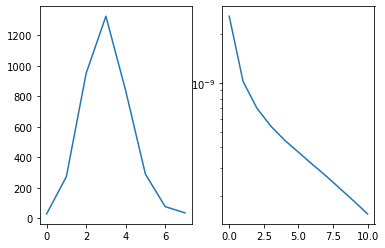

In [7]:
# plot mean signal
subplot(121)
plot(pcounts.mean(axis=0))
subplot(122)
semilogy(ps.mean(axis=0))

In [8]:
# Computing covariance matrix
cov_ps=np.cov(ps, rowvar=False)
cov_pcounts=np.cov(pcounts, rowvar=False)
cov_comb=np.cov(comb, rowvar=False)

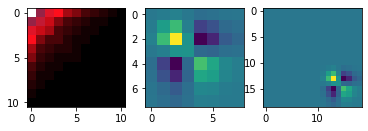

In [9]:
subplot(131)
imshow(cov_ps,cmap='gist_stern')
subplot(132)
imshow(cov_pcounts)
subplot(133)
imshow(cov_comb)

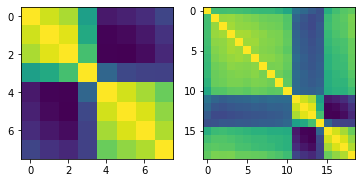

In [10]:
subplot(121)
imshow(np.corrcoef(pcounts.T))
subplot(122)
imshow(np.corrcoef(comb.T))

In [11]:
#Now, loading the jacobians of the power spectrum 
ps_jac = []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac', filename), 'rb'))
        ps_jac.append(res['jac_ps'])

In [12]:
#Now, loading the jacobians of the peak counts
pcounts_jac= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_peak_counts/jac"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_peak_counts/jac', filename), 'rb'))
        pcounts_jac.append(res['jac_pc'])

In [13]:
ps_jac= stack(ps_jac, axis=0)
pcounts_jac = stack(pcounts_jac, axis=0)
comb_jac = concatenate([ps_jac,pcounts_jac[:77]], axis=1)

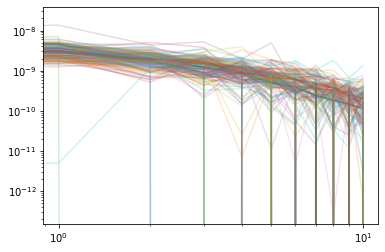

In [14]:
loglog(ps_jac.mean(axis=0))
for i in range(len(ps_jac)):
    loglog(ps_jac[i], alpha=0.2)

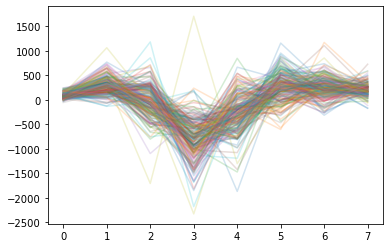

In [15]:
plot(pcounts_jac.mean(axis=0))
for i in range(len(pcounts_jac)):
    plot(pcounts_jac[i], alpha=0.2)

In [16]:
dmu_ps = ps_jac.mean(axis=0)
dmu_pcounts = pcounts_jac.mean(axis=0)
dmu_comb = comb_jac.mean(axis=0)

In [17]:
# Annnnd let's try to get our first fisher matrix
Fps = dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps

In [18]:
Fpcounts = dmu_pcounts.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts

In [19]:
Fcomb = dmu_comb.T @ (np.linalg.inv(cov_comb)) @ dmu_comb

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

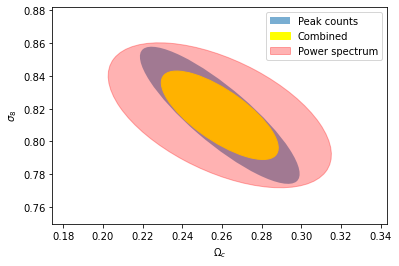

In [21]:
ax = plt.axes()
ax1=plot_contours(Fpcounts, [0.2589,
                  0.8159],alpha=1.6)
ax2=plot_contours(Fcomb, [0.2589,0.8159], color='yellow',alpha=1)
ax3=plot_contours(Fps, [0.2589,
                  0.8159], color='red',alpha=0.3)
xlabel('$\Omega_c$')
ylabel('$\sigma_8$')
plt.legend([ax1,ax2,ax3],['Peak counts','Combined', 'Power spectrum'])
savefig('Fisher.png',dpi=250)